# Census Income Project

In [1]:
# Importing all the necessary libraries here.

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

In [2]:
conda install -c conda-forge py-xgboost

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb

In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import lightgbm as lgb

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")

In [7]:
df # checking the first 5 and last 5 rows of our dataset

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In the above cell we can see the first 5 and last 5 rows of our dataset. We see that our dataset has a total of 32560 rows and 15 columns. We see a mix of numeric data columns and text data columns that will need to be converted to a numerical format before we can train our model. Also the problem statement says that we should predict the column "income" which has 2 classes "<=50K" and ">50K", so it makes it as a classification problem!

# Exploratory Data Analysis (EDA)

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Making sure we don't have any small details displayed in our Jupiter notebook in future observations.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Using the information method we can see that there are 6 columns with integer data type and 9 columns with object data type. For the purpose of easy analysis, we will try to extend these pillars further.

In [10]:
# getting list of object data type column names
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are: ", object_datatype)


# getting the list of float data type column names
integer_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'int64':
        integer_datatype.append(x)
print(f"\nFloat Data Type Columns are: ", integer_datatype)

Object Data Type Columns are:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Float Data Type Columns are:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


We have successfully bifurcated object datatype column names and integer data type column names. Since we don't have to worry about outliers and skewness in categorical columns, we can use this separate column names to pre-process only numeric continuous columns.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
Fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
Education_num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
Capital_gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
Capital_loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
Hours_per_week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


Using the describe method we can take a look at the numeric data type columns and observe the distribution of integer data among them. The first column shows the count/rows occupied by the column and since they all have the same number, it indicates that they do not contain any missing values. Moving to other columns I see abnormality in "capital_gain" and "capital_loss" column with 0.0 value for minimum value, 25% data slot, 50% data slot and 75% data slot.

Although the maximum values ​​are quite large in number, so they can be called some kind of outliers, but when we statistically speaking such data are possible and hence we will either retain them or treat them as per our requirement. I will

In [12]:
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

It looks like we do not have any missing data present in our dataset for any of the columns.

<AxesSubplot:>

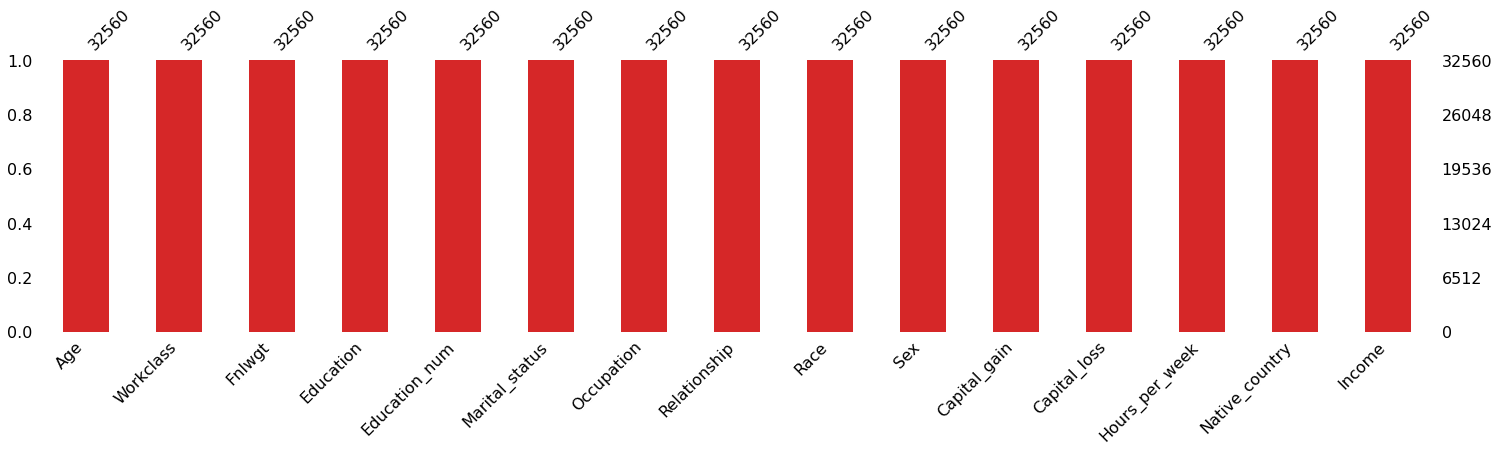

In [13]:
missingno.bar(df, figsize = (25,5), color="tab:red")

We are able to depict the missing values ​​information in a bar plot format where we can clearly see that all the columns have all the rows filled with data and no null values ​​are present

In [14]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (32560, 15)
Rows and Columns after dropping duplicates:  (32536, 15)


With the drop_duplicates option I am getting rid of all the duplicate values present in our dataset.

In [15]:
df.nunique().to_frame("Unique Values")

,Unique Values
Age,73
Workclass,9
Fnlwgt,21647
Education,16
Education_num,16
Marital_status,7
Occupation,15
Relationship,6
Race,5
Sex,2


The nunique method lists down the number of all the unique data present in each column of our dataset.

In [16]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*120)

Workclass
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
Education
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
Marital_status
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64
Occupation
 Prof-specialty       41

In the above cell we are taking a look at all the unique values ​​of the Object data type column. Keeping an eye on the values, we "?" Were able to see the data shown. In the columns "Workclass", "Business" and "Native_Country". We have to replace all the lines that contain this "?" First with a proper name in them so that encoding these values ​​during and after visualizing would make more sense.

In [17]:
df['Workclass'].replace({' ?':' Other-Working-Class'},inplace=True)
df['Occupation'].replace({' ?':' Other-Occupation'},inplace=True)
df['Native_country'].replace({' ?':' Others'},inplace=True)

We have successfully replaced all the "?" data present in the columns "Workclass", "Occupation" and "Native_country" with meaningful values.

# Visualization

In [18]:
print(f"Object Data Type Column Names: ", object_datatype)
print(f"\nInteger Data Type Column Names: ", integer_datatype)

Object Data Type Column Names:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Integer Data Type Column Names:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


Lisiting out the column names for object datatype and integer datatype respectively.

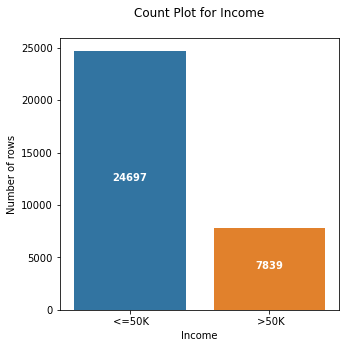

In [19]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Income'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that our target label "Income" column has imbalaned dataset that will need to be taken care of before we start building our classification machine learning model

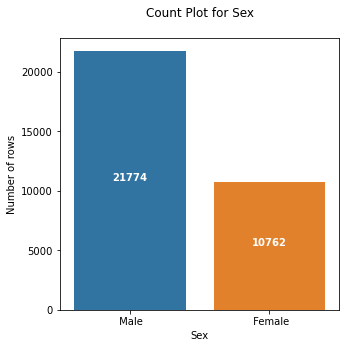

In [20]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Sex'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that the number of data values for male is higher than that of it's female counterparts.

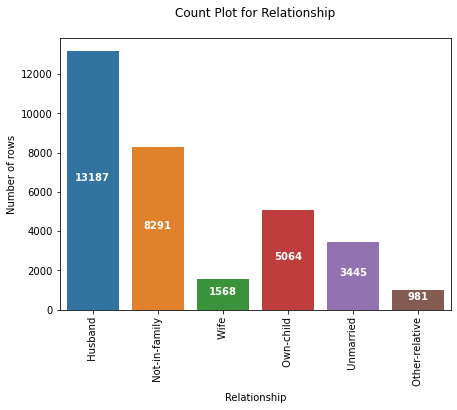

In [21]:
try:
    plt.figure(figsize=(7,5))
    col_name = 'Relationship'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we see that in the "Relationship" status the values for husband is the highest and other relative has the lowest data.

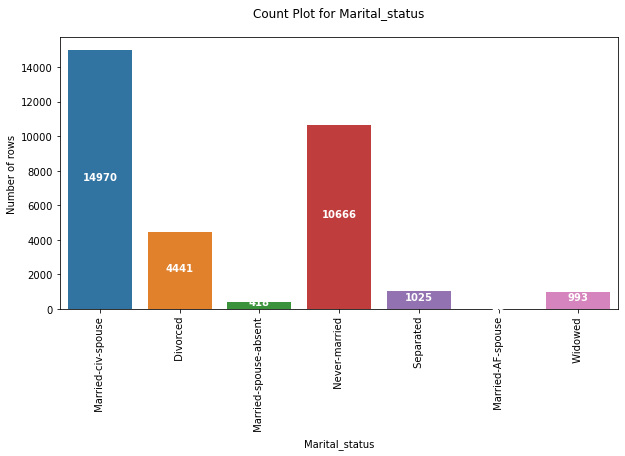

In [22]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Marital_status'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Marital Status column has married spouse and never married people on the higher edge as compared to the other values.

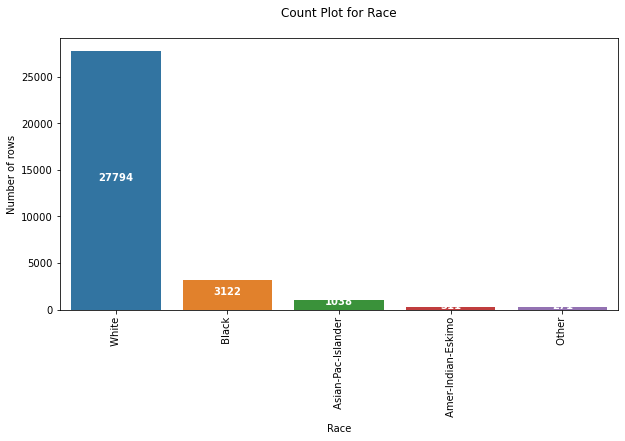

In [23]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Race'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Race column mostly comprises of White people in the dataset.

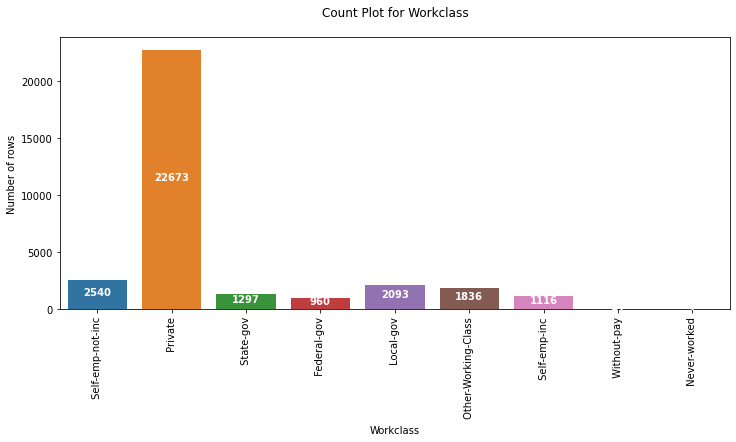

In [24]:
try:
    plt.figure(figsize=(12,5))
    col_name = 'Workclass'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that in the Work Class column the highest number of people work for private sector and the other work classes or people who are unemployed is quite less to negligible.

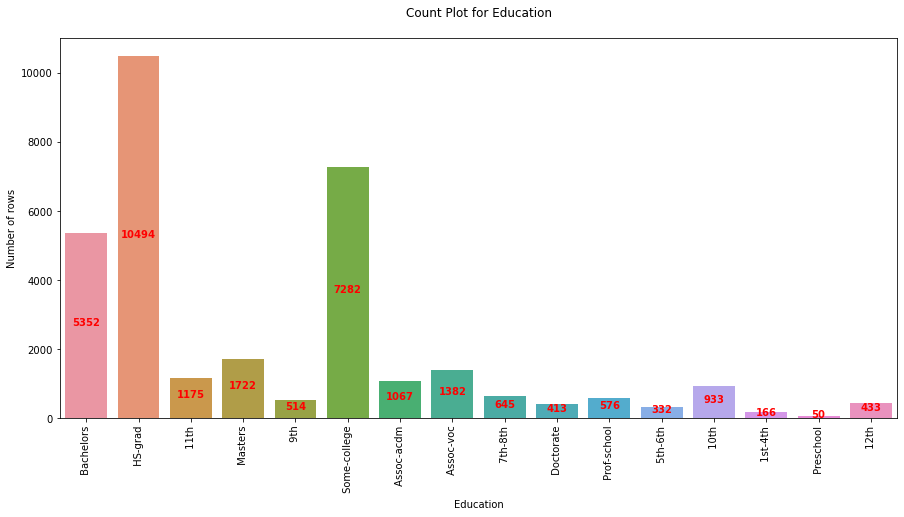

In [25]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Education'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='r')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the HS grade has the highest value in the Education column, followed by some colleges and graduates. The data coverage of the remaining education categories in our dataset is quite low.

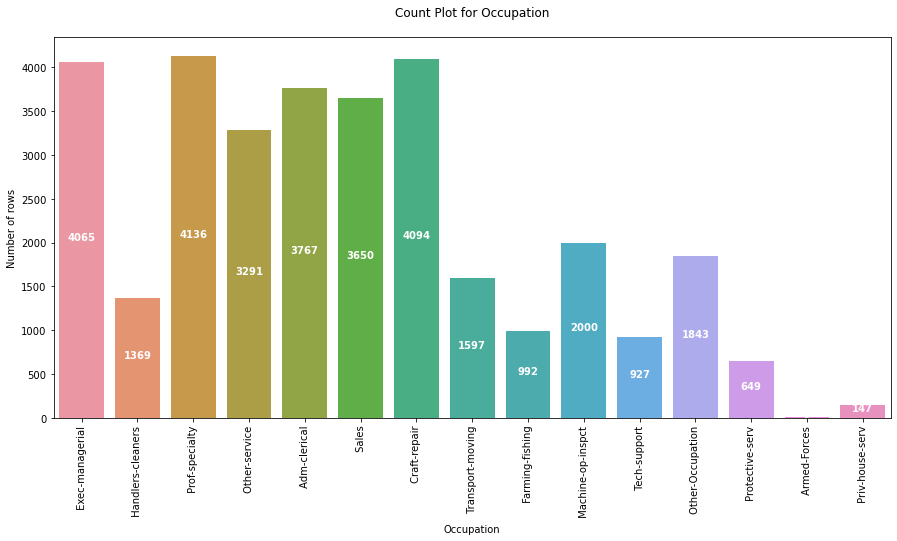

In [26]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Occupation'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass 

From the above calculation we can see that there are various categories in the occupation column out of which people in armed forces are lowest and some are increasing in craft repair, executive managers and people with certain professional specialties.

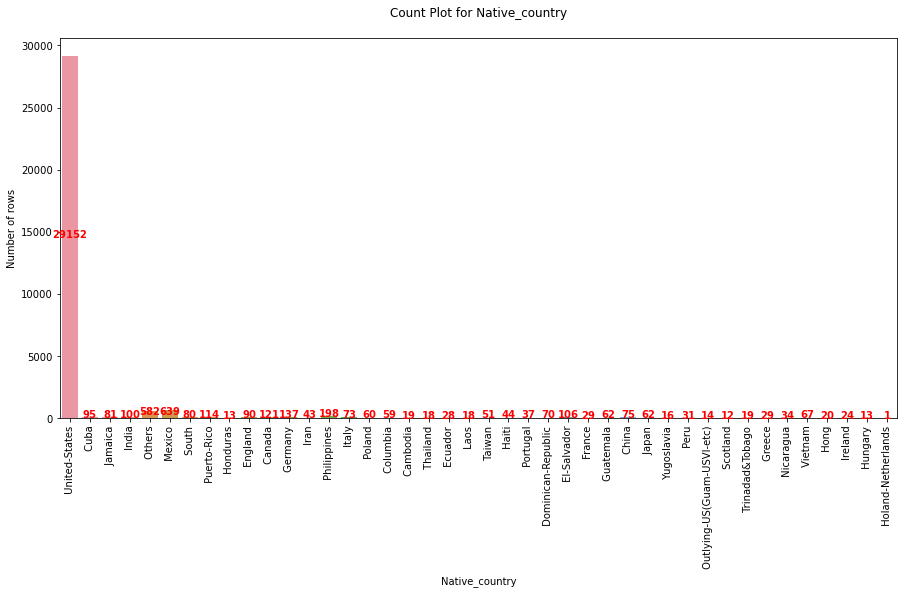

In [27]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Native_country'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name])

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='r')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we can clearly see that the Native Country column has the highest value for Mexico and others followed by the US, while the rest of the ranges have a minimal to negligible amount of data coverage.

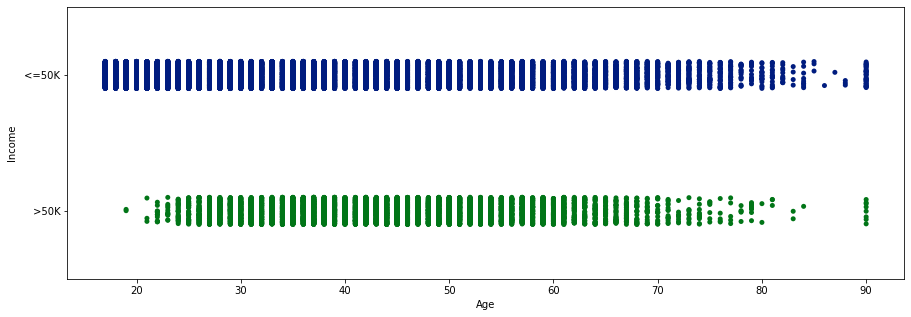

In [28]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Age', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that young people hardly have income more than 50K.

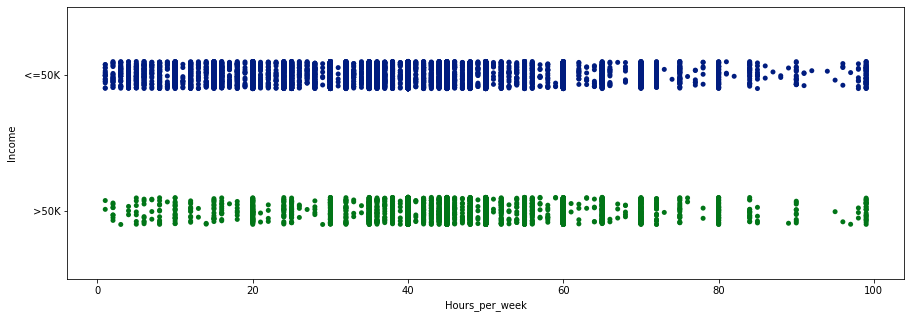

In [29]:
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Hours_per_week', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that people whose income is less than or equal to 50K put in more hours per week as income than those who earn more than 50K.

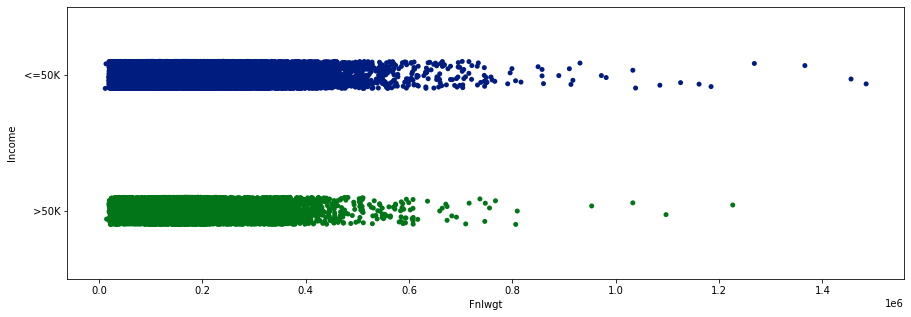

In [30]:
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Fnlwgt', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the final weight has data coverage on a higher scale for people in the <=50K income bracket as compared to the people in >50K income bracket.

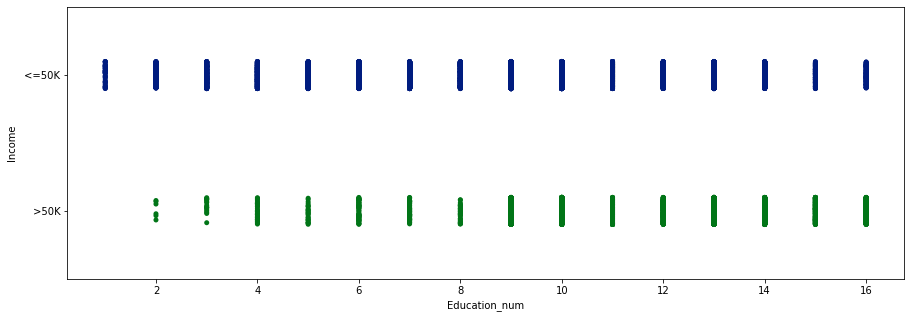

In [31]:
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Education_num', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the low education number is almost negligible for people with income >50K and hence it also emphasizes the importance of education.

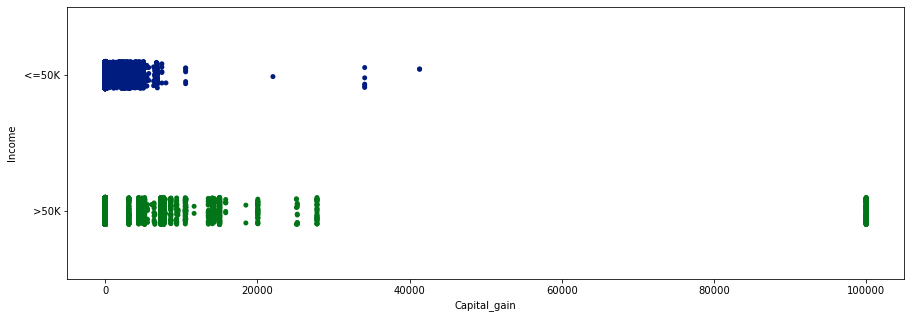

In [32]:
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Capital_gain', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital gain is on a higher scale for people with income >50K

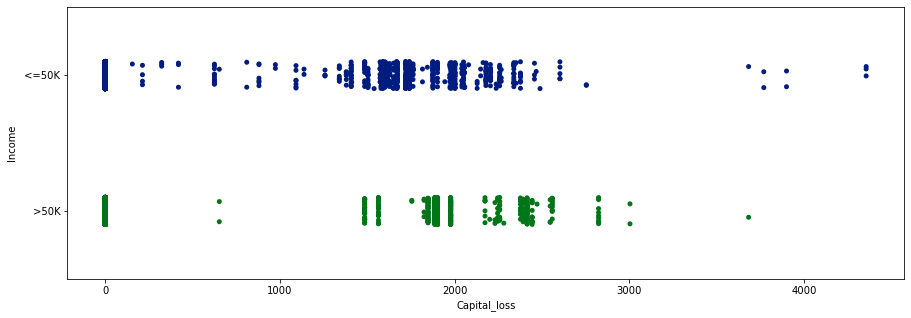

In [33]:
plt.figure(figsize=(15,5))
sns.stripplot(x = 'Capital_loss', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital loss for people with income >50K is considerably less than people with income <=50K

Text(0, 0.5, 'Percentage of People')

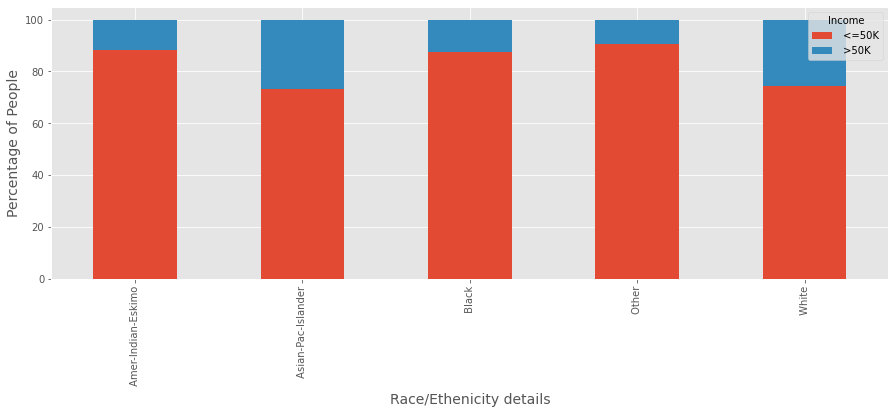

In [34]:
plt.style.use('ggplot')
tbl = pd.crosstab(df['Race'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Race/Ethenicity details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us different ethenicity race group folks and the income variations between them.

Text(0, 0.5, 'Percentage of People')

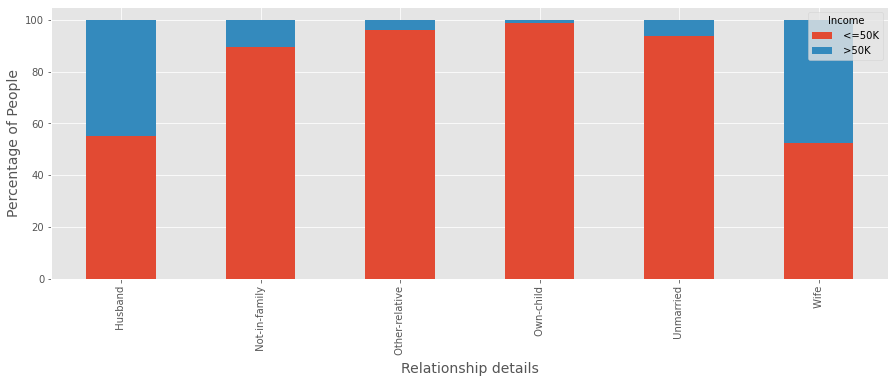

In [35]:
tbl = pd.crosstab(df['Relationship'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Relationship details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The cross tab bar plot above shows us the differences in income statements for people in different relationship statuses. People who are earning >50K are mostly from relationship status spouse

Text(0, 0.5, 'Percentage of People')

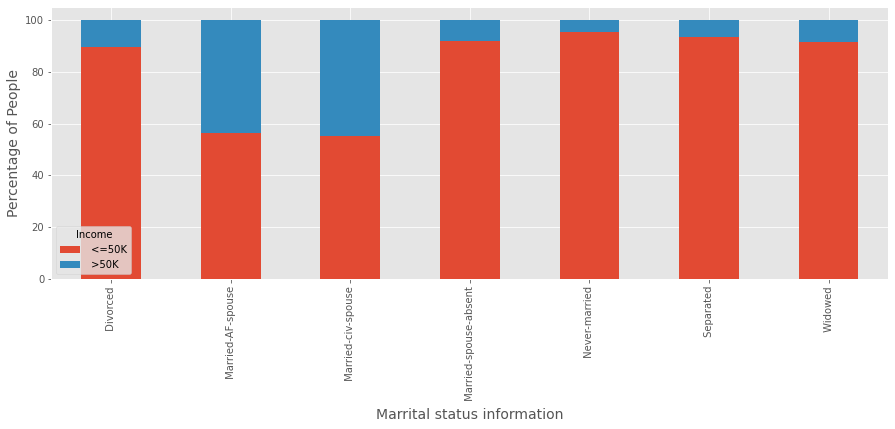

In [36]:
tbl = pd.crosstab(df['Marital_status'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Marrital status information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the marrital status of people who have income either <=50K or >50K

Text(0, 0.5, 'Percentage of People')

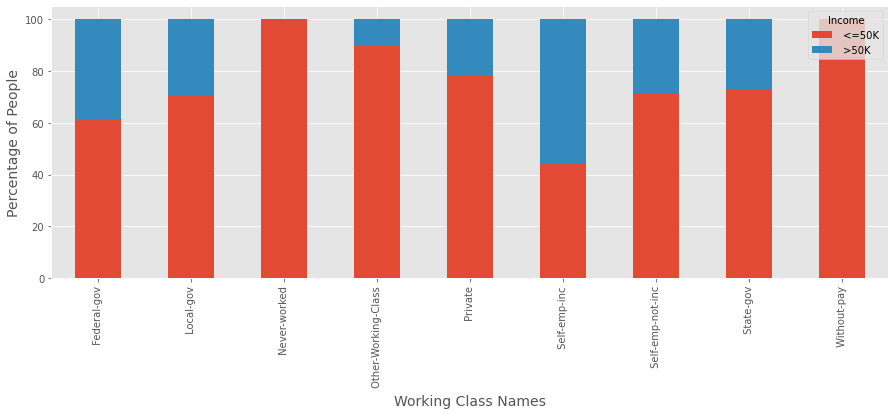

In [37]:
tbl = pd.crosstab(df['Workclass'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Working Class Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the information of working class and those who have never worked or are sitting without salary, they clearly come under <=50K income group whereas most of the people who are self employed or business owners If they are able to earn income > 50K.

Text(0, 0.5, 'Percentage of People')

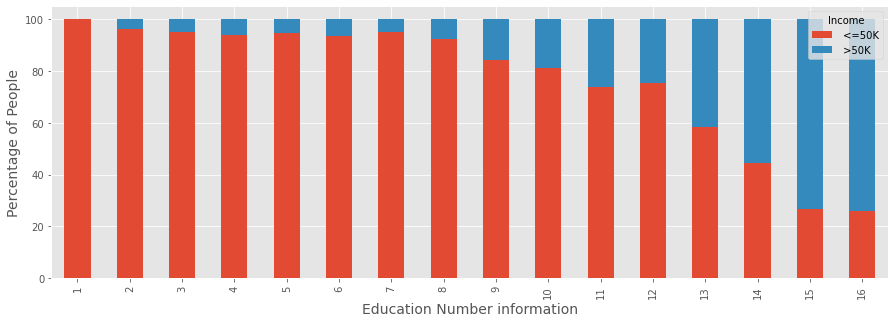

In [38]:
tbl = pd.crosstab(df['Education_num'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education Number information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the education number scale which shows that to earn an income of >50K you must have a high educational number emphasizing the importance on the educational front.

Text(0, 0.5, 'Percentage of People')

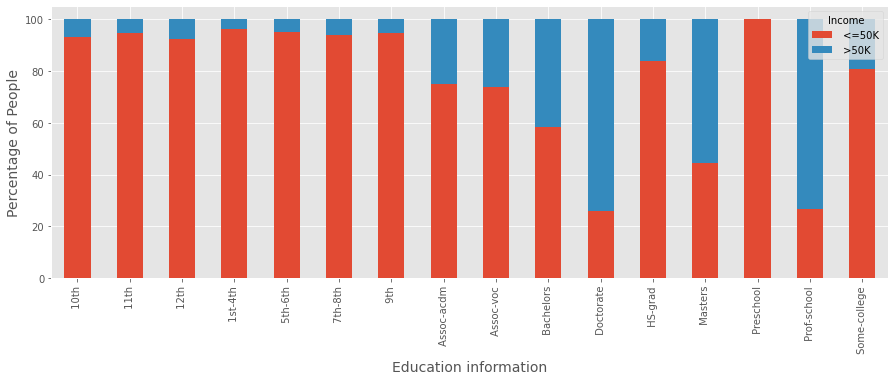

In [39]:
tbl = pd.crosstab(df['Education'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the different types of education for the people and the scale of their income. It seems that people with income above 50 thousand have doctorates, masters and qualifications in professional school.

Text(0, 0.5, 'Percentage of People')

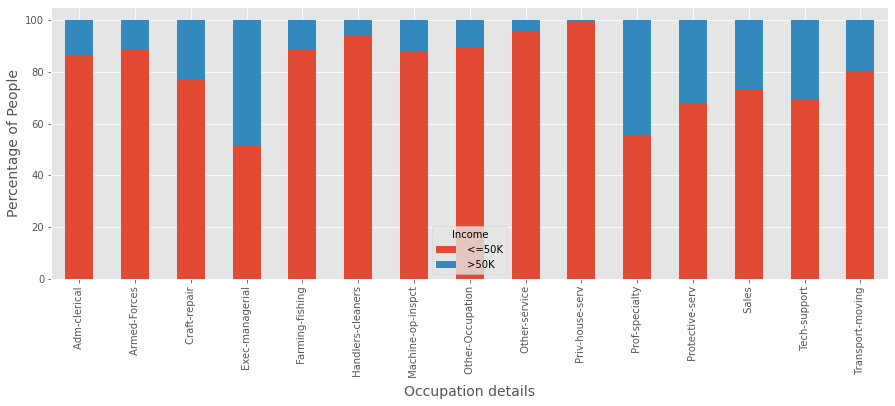

In [40]:
tbl = pd.crosstab(df['Occupation'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Occupation details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Above cross tab bar plot shows us all business information for people and helps in executive managerial position, professional specialty position, protective services, technical support position and sales position to earn income of >50K.

Text(0, 0.5, 'Percentage of People')

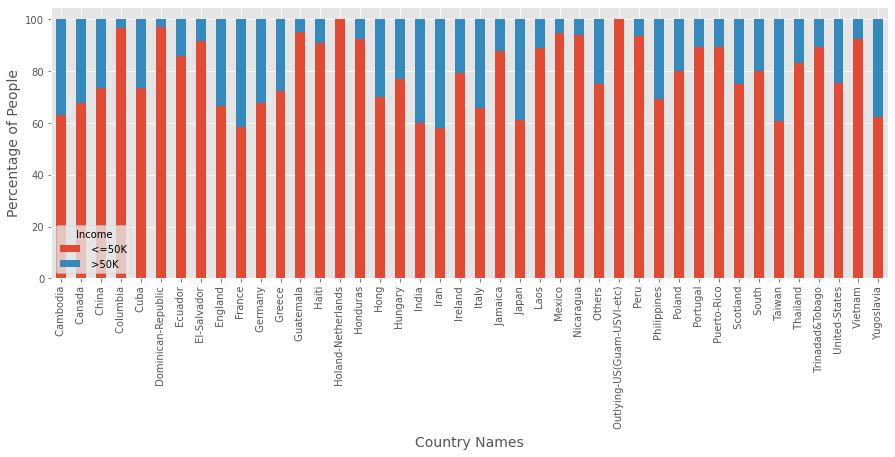

In [41]:
tbl = pd.crosstab(df['Native_country'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).sort_values(col_name).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Country Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the native country details for people settled in the US. In order to earn >50K the native country details recorded are for Cambodia, Canada, France, Germany, Greece, Hong Kong, India, Iran, Italy, Japan, Phillipines, Taiwan, Yugoslavia.

Text(0, 0.5, 'Percentage of People')

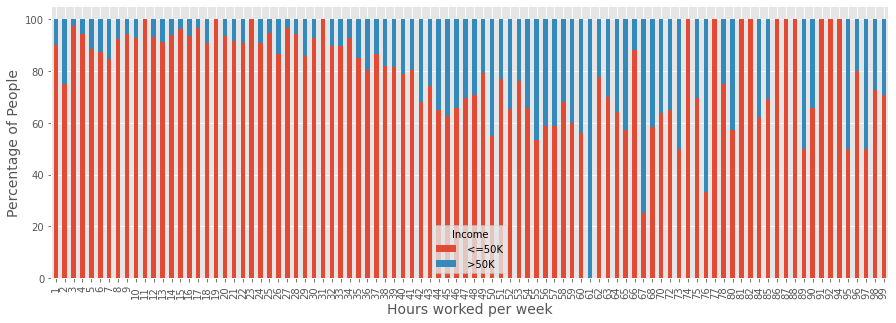

In [42]:
tbl = pd.crosstab(df['Hours_per_week'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Hours worked per week', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us that people with >50K income mostly work 61 hours per week or range from 50-80 hours per week mostly.

Text(0, 0.5, 'Percentage of People')

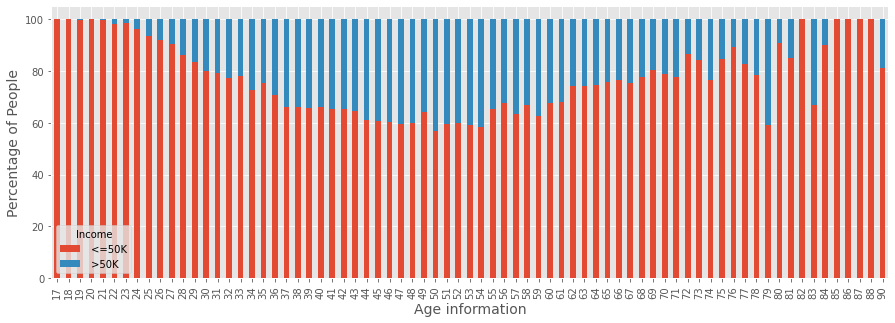

In [43]:
tbl = pd.crosstab(df['Age'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Age information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us that younger people mostly have an income of <=50K and older people generally have an income of >50K.

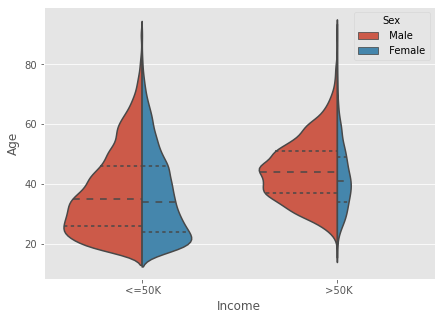

In [44]:
plt.figure(figsize=(7,5))
sns.violinplot(x="Income", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male in any age group and income group have a higher number than their female counterparts.

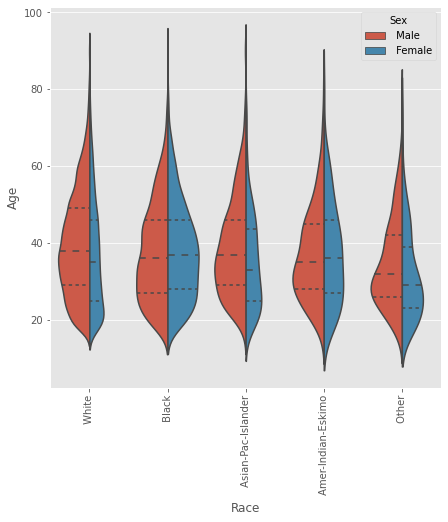

In [45]:
plt.figure(figsize=(7,7))
sns.violinplot(x="Race", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that female with black ethinicity of any age group is higher than the other ethinicity group females.

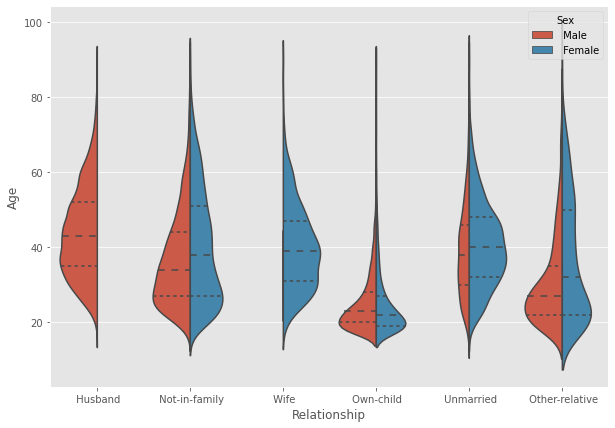

In [46]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Relationship", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that people in the own child relationship age from 10-40. Also we have female who are unmarried more than the male counter parts.

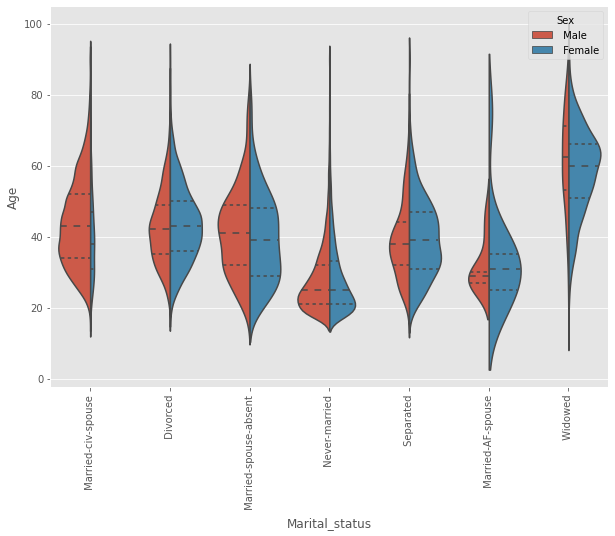

In [47]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Marital_status", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

The above violin plot shows us that men are more likely than women to have marital status as married spouses and that widows outnumber women than men.

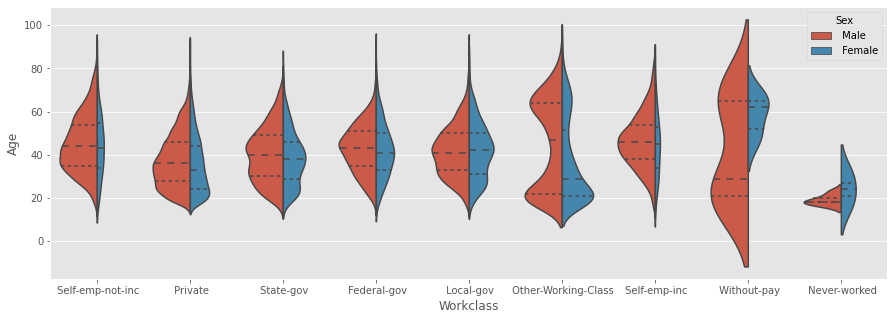

In [48]:
plt.figure(figsize=(15,5))
sns.violinplot(x="Workclass", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male cover most of the working class sectors in each category as compared to the females

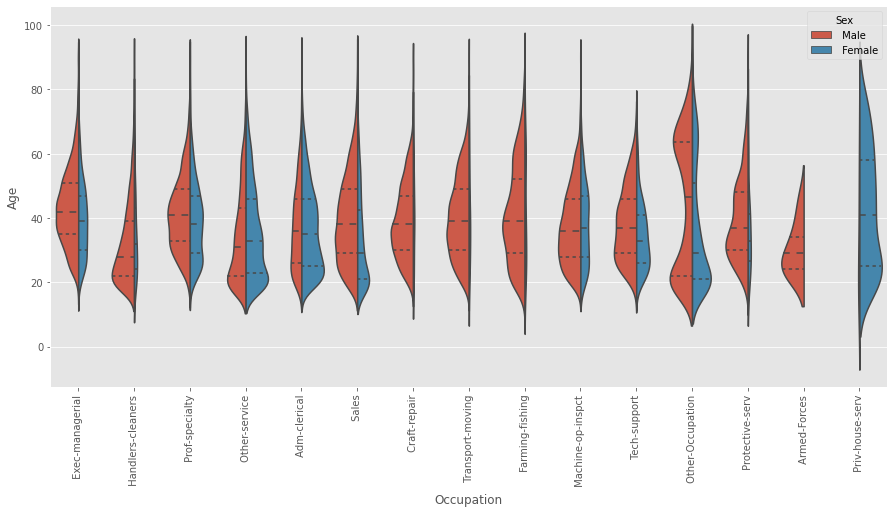

In [49]:
plt.figure(figsize=(15,7))
sns.violinplot(x="Occupation", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

The violin plot above shows that the designations of private domestic services are mostly women aged 20-60, while occupations such as craft repair, transport transportation, farming/fishing, protective/security service and the armed forces are more numerous. . is more. Data coverage for men.

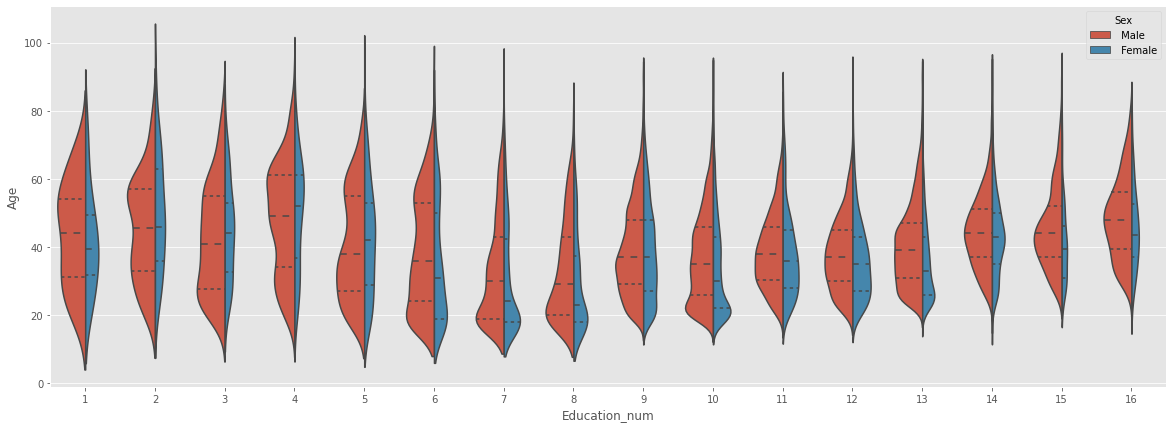

In [50]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education_num", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that males in all age group have a higher education number compared to their female counter parts.

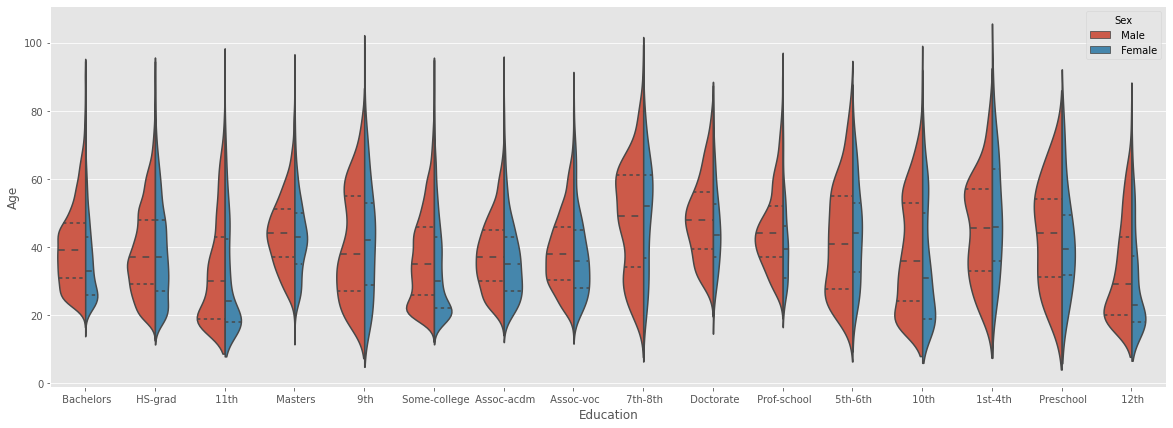

In [51]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education", y="Age", hue="Sex", data=df, 
               split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that just like the education number the education category sees more number of males than their female counter parts giving us a red flag on how female education is a concern.

# Encoding the categorical object datatype columns

In [52]:
# Label Encoder

le = LabelEncoder()
df["Income"] = le.fit_transform(df["Income"])
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


I have used LabelEncoder to convert the object data type in our label column "Income" to a numerical format.

In [53]:
# Ordinal Encoder

oe = OrdinalEncoder()
df['Workclass'] = oe.fit_transform(df['Workclass'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Marital_status'] = oe.fit_transform(df['Marital_status'].values.reshape(-1,1))
df['Occupation'] = oe.fit_transform(df['Occupation'].values.reshape(-1,1))
df['Relationship'] = oe.fit_transform(df['Relationship'].values.reshape(-1,1))
df['Native_country'] = oe.fit_transform(df['Native_country'].values.reshape(-1,1))
df['Race'] = oe.fit_transform(df['Race'].values.reshape(-1,1))
df['Sex'] = oe.fit_transform(df['Sex'].values.reshape(-1,1))
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6.0,83311,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,39.0,0
1,38,4.0,215646,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,39.0,0
2,53,4.0,234721,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,39.0,0
3,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,4.0,0
4,37,4.0,284582,12.0,14,2.0,3.0,5.0,4.0,0.0,0,0,40,39.0,0


I could have used one hot encoder here but I preferred to use OrdinalEncoder to ensure that the number of columns do not get increased unnecessarily.

In [54]:
print(f"Shape of our data frame post encoding is", df.shape)
df.isnull().sum()

Shape of our data frame post encoding is (32536, 15)


Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

I am checking the number of rows and columns present in our dataset after applying the enconding techniques and ensuring that there are no null values present in them.

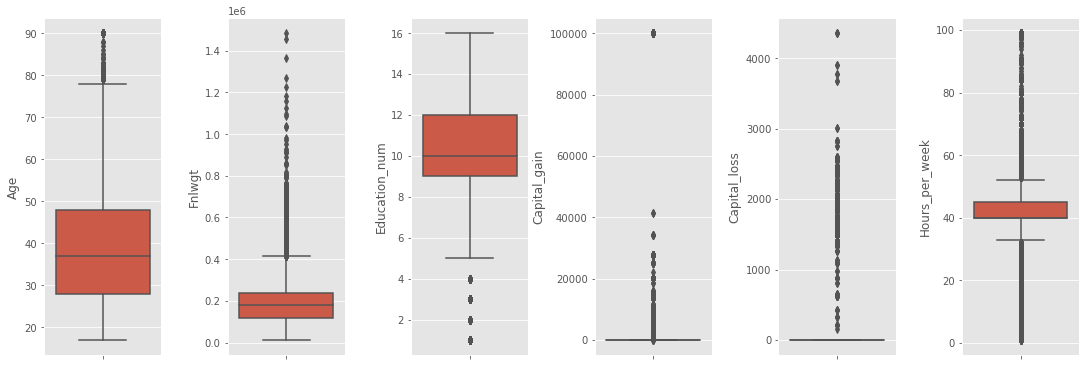

In [55]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of box plot we can see the outlier details present in our numerical data columns which will need to be treated.

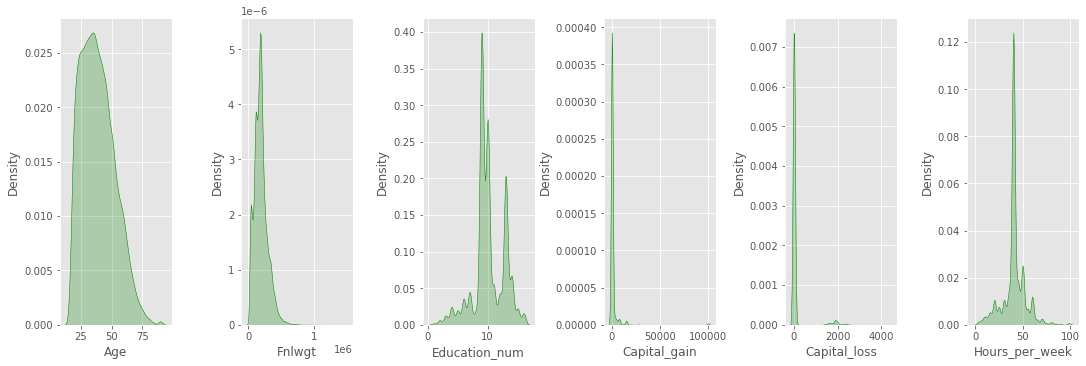

In [56]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="g", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

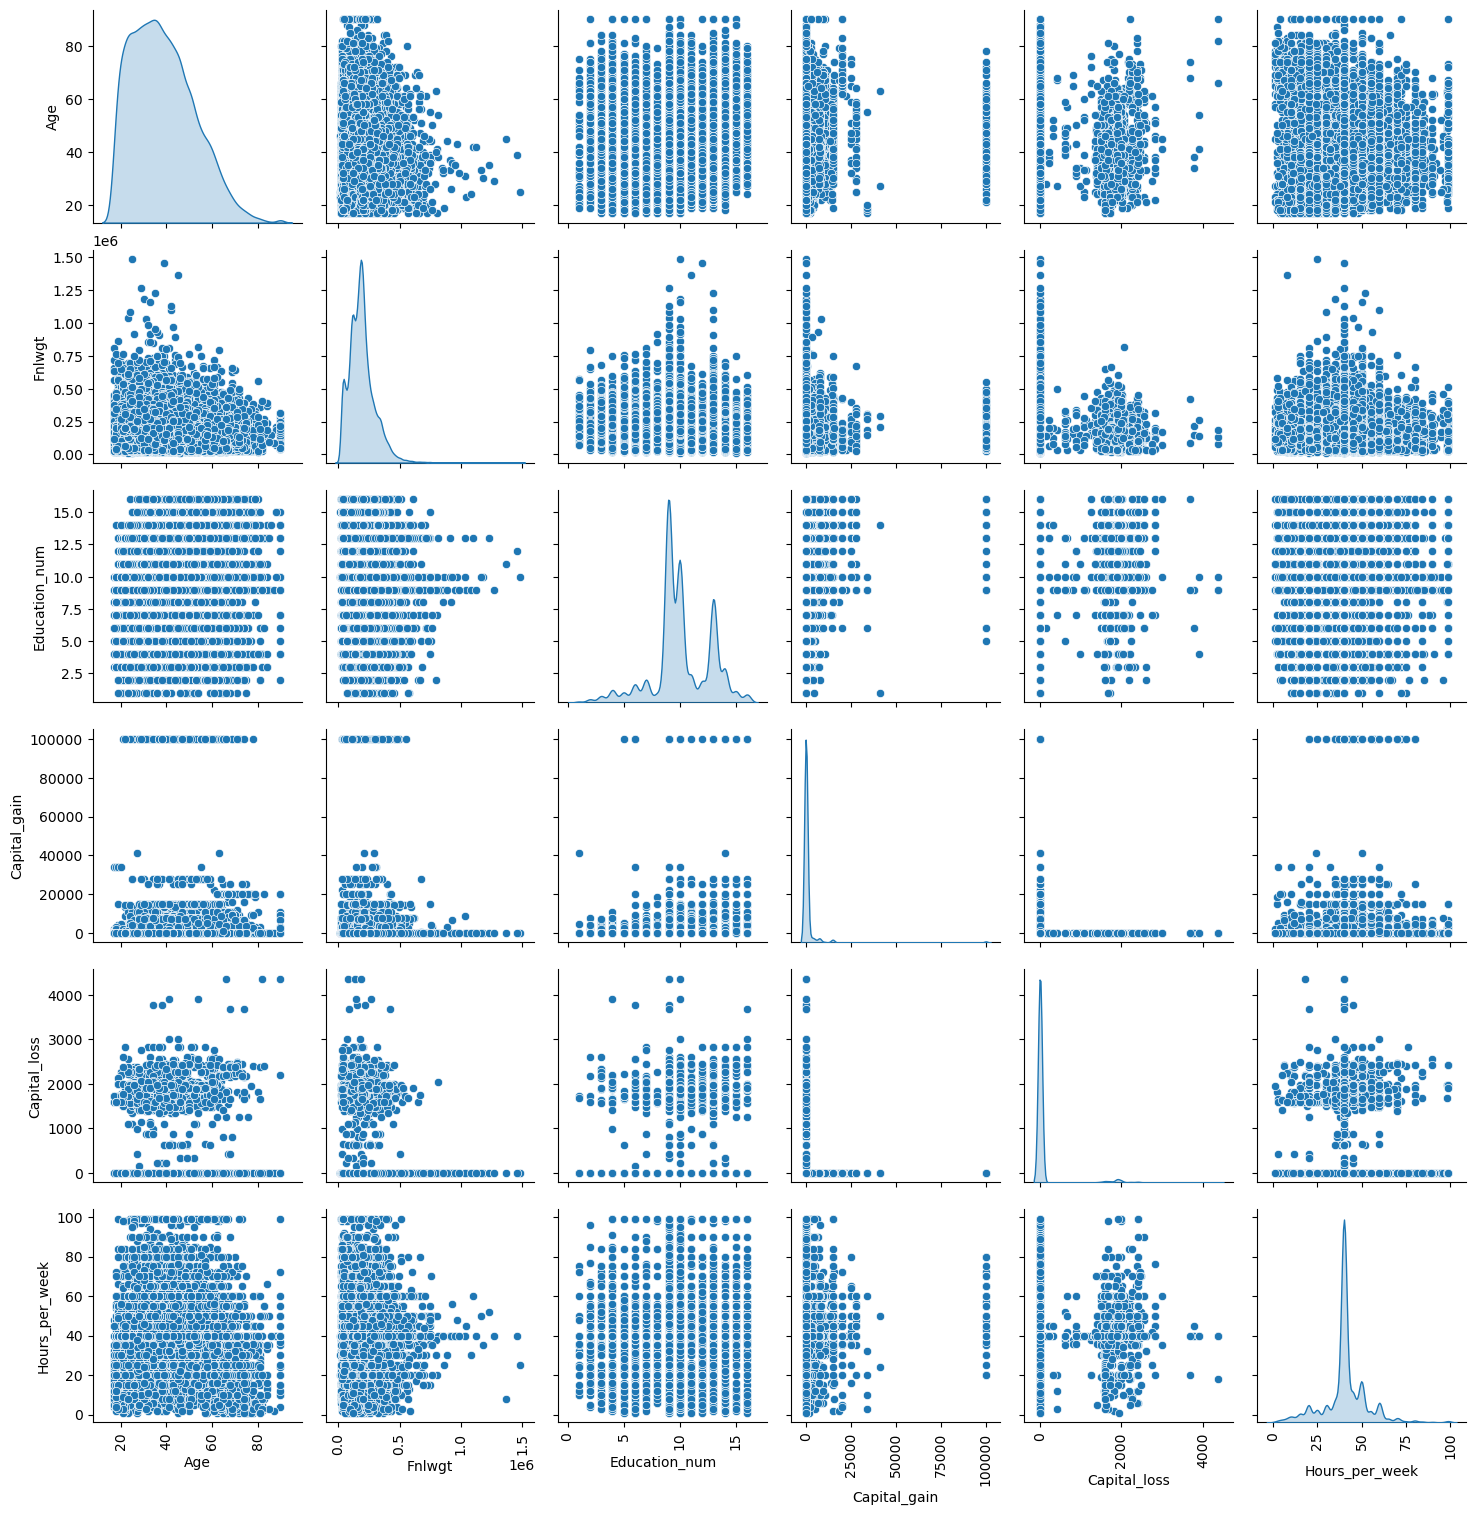

In [57]:
num_values = df.drop(['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
                      'Native_country', 'Income'], axis=1)
plt.style.use('default')
g = sns.pairplot(num_values, diag_kind="kde")
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns and show us how the data points are available in each of them.

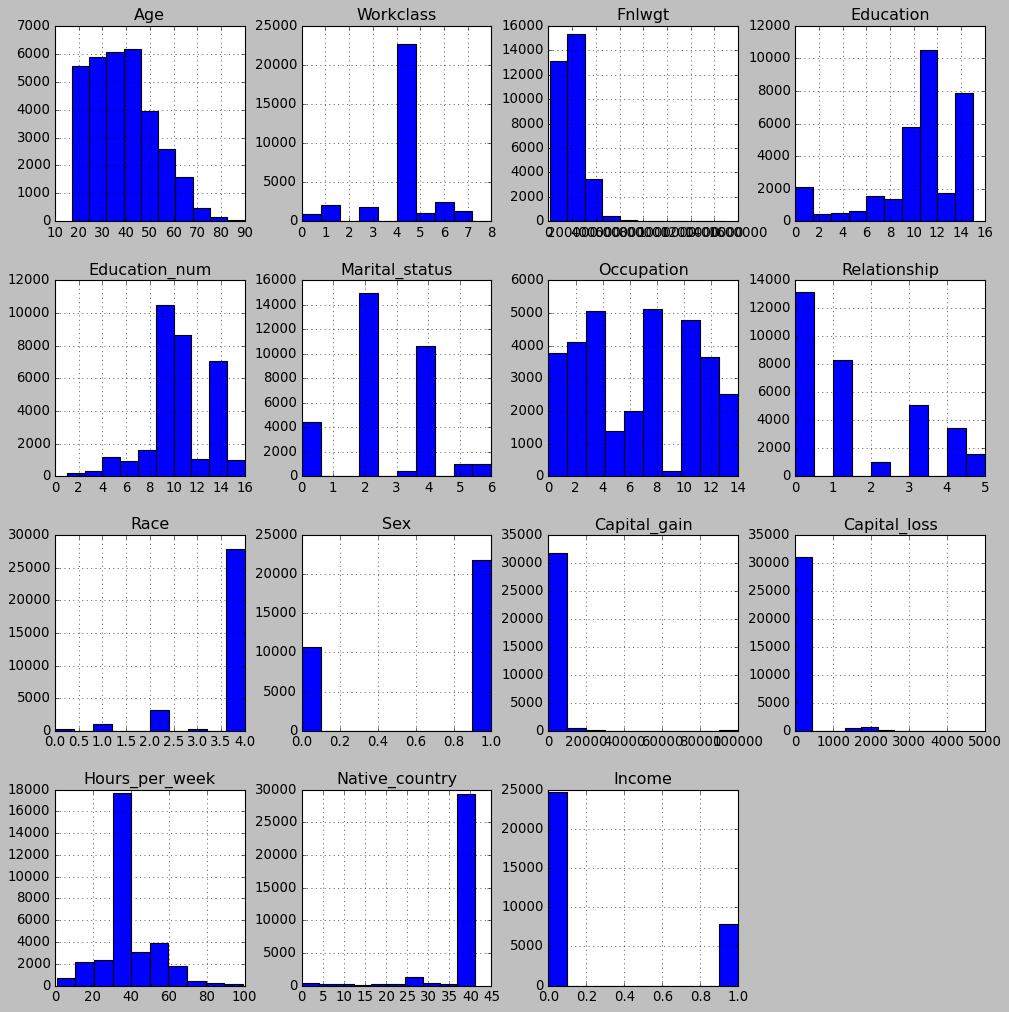

In [58]:
plt.style.use('classic')
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

# Correlation using a Heatmap

Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.

Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down

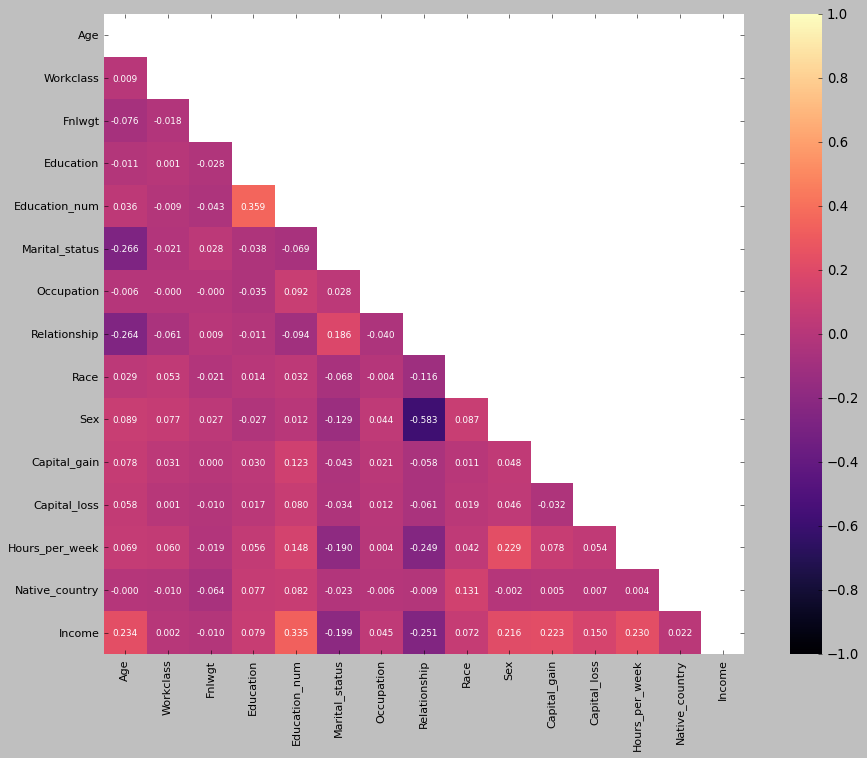

In [59]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="magma", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we can see the correlation details plus we can determine that there is no multi colinearity issue between our columns.

# Correlation Bar Plot comparing features with our label

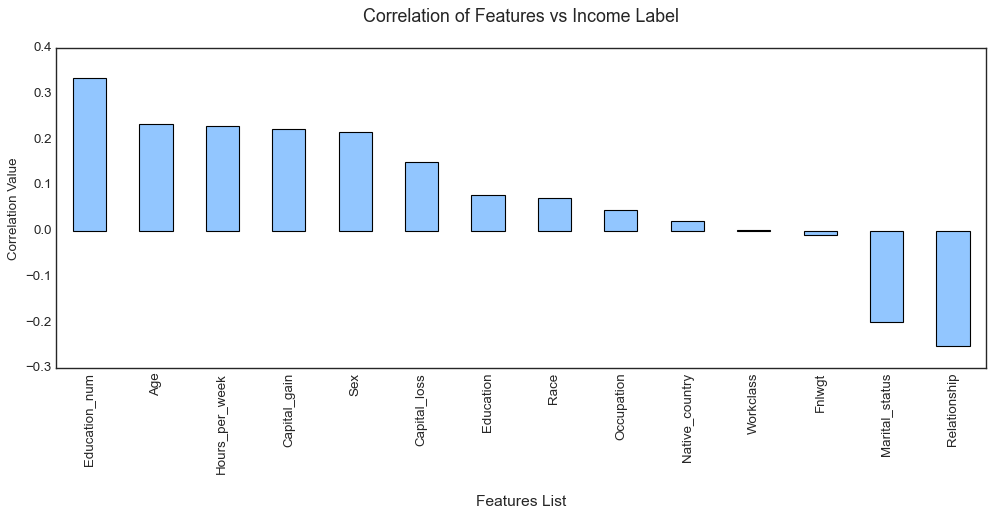

In [60]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(15,5))
df_corr['Income'].sort_values(ascending=False).drop('Income').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clear picture on the positive and negative correlation columns, we plotted this bar and we see that column relationship and marital status correlated negatively with all other feature columns only positively. we are correlated label column

# Using Z Score to remove outliers

In [61]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (32536, 15)
Shape of the dataframe after removing outliers:  (27763, 15)
Percentage of data loss post outlier removal:  14.669904106220802


I have used the Z score method to remove the outliers and even though we are losing 14.669904106220802 % of data I am able to afford that loss considering we have a lot of rows in our datatset to be used while model building.

In [62]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt             0.629184
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       4.929937
Capital_loss      29.510814
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

With the skew method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value.

# Using Log Transform to fix skewness

In [63]:
for col in integer_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied Log Transformation on our numerical integer datatype columns to ensure that we do not have skewness in our dataset.

In [64]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt            -0.955984
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       3.111123
Capital_loss      25.003969
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

We have reduced the asymmetry from our numerical columns and this can be seen above whereas we have ignored the asymmetry and extraneous details for our categorical data.

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [65]:
X = df.drop('Income', axis=1)
Y = df['Income']

I have seperated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

# Resolving the class imbalance issue in our label column.

In [66]:
Y.value_counts()

0    21535
1     6228
Name: Income, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [67]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

SMOTE is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [68]:
Y.value_counts()

0    21535
1    21535
Name: Income, dtype: int64

After applying the oversampling we are re-listing the values ​​in our label column to cross validate the updated information. Here we see that we have successfully solved the class imbalance problem and now all the categories have the same data ensuring that the machine learning model is not biased towards one category.

# Feature Scaling

In [69]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
0,0.786048,1.541193,-1.147131,-0.433033,1.014387,-0.319740,-0.812333,-0.730258,0.308474,0.606722,-0.382089,-0.032644,-2.666228,0.212472
1,-0.166840,0.045431,0.522464,0.134971,-0.631918,-1.850924,-0.355223,-0.106472,0.308474,0.606722,-0.382089,-0.032644,-0.153694,0.212472
2,1.024270,0.045431,0.671261,-2.705049,-1.455071,-0.319740,-0.355223,-0.730258,-3.492392,0.606722,-0.382089,-0.032644,-0.153694,0.212472
3,-0.246248,0.045431,1.009416,0.418973,1.425964,-0.319740,-0.812333,2.388671,0.308474,-1.693927,-0.382089,-0.032644,-0.153694,0.212472
4,0.706640,0.045431,0.000555,-1.285039,-2.278224,0.445852,0.330442,-0.106472,-3.492392,-1.693927,-0.382089,-0.032644,-2.387057,-5.789498


I'hv scaled my feature data to ensure that there is no issue with the data biasness over a particular column instead a standardization will occur helping us in having a uniform dataset value.

# Finding best random state for building Classification Models

In [70]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 77.57243684992571 on Random State 725


with the help of random state selection process we have found our lucky number to be "5" amongst 1-1000 range

# Feature importance bar graph

,Importance
Features,
Relationship,0.165
Marital_status,0.147
Age,0.140
Fnlwgt,0.121
Occupation,0.073
Education_num,0.069
Hours_per_week,0.068
Capital_gain,0.061
Education,0.049


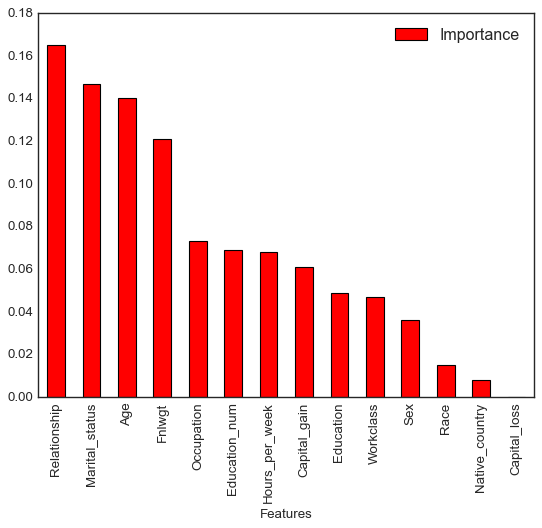

In [71]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='red')
importances

Here with the help of RandomForestClassifier we are able to list the importance or priority given to the column according to the participation or weightage of the column in the prediction of our label.

# Machine Learning Model for Classification with Evaluation Metrics

In [72]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=725)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)


I have defined a class that will do the train-test split, train the machine learning model, predict the label value, get the accuracy score, generate the classification report, get the cross validation score and the difference between the accuracy score . Cross validation scores for any machine learning model that calls for this function.

In [73]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

In [74]:
# Logistic Regression

model=LogisticRegression()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      5403
           1       0.77      0.79      0.78      5365

    accuracy                           0.78     10768
   macro avg       0.78      0.78      0.78     10768
weighted avg       0.78      0.78      0.78     10768

Accuracy Score: 77.57243684992571
Cross Validation Score: 76.65660552588808

Accuracy Score - Cross Validation Score is 0.9158313240376259


Created the Logistic Regression Model and checked for it's evaluation metrics.

In [75]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      5403
           1       0.81      0.91      0.85      5365

    accuracy                           0.84     10768
   macro avg       0.85      0.84      0.84     10768
weighted avg       0.85      0.84      0.84     10768

Accuracy Score: 84.45393759286776
Cross Validation Score: 83.9215231019271

Accuracy Score - Cross Validation Score is 0.532414490940667


Created the Support Vector Classifier Model and checked for it's evaluation metrics.

In [76]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      5403
           1       0.84      0.89      0.87      5365

    accuracy                           0.86     10768
   macro avg       0.87      0.86      0.86     10768
weighted avg       0.87      0.86      0.86     10768

Accuracy Score: 86.42273402674591
Cross Validation Score: 86.01114464824704

Accuracy Score - Cross Validation Score is 0.4115893784988742


Created the Decision Tree Classifier Model and checked for it's evaluation metrics.

In [77]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      5403
           1       0.86      0.93      0.89      5365

    accuracy                           0.89     10768
   macro avg       0.89      0.89      0.89     10768
weighted avg       0.89      0.89      0.89     10768

Accuracy Score: 88.69799405646359
Cross Validation Score: 87.90805665196191

Accuracy Score - Cross Validation Score is 0.7899374045016714


Created the Random Forest Classifier Model and checked for it's evaluation metrics

In [78]:
# K Neighbors Classifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      5403
           1       0.80      0.90      0.85      5365

    accuracy                           0.84     10768
   macro avg       0.85      0.84      0.84     10768
weighted avg       0.85      0.84      0.84     10768

Accuracy Score: 84.05460624071323
Cross Validation Score: 83.55003482702577

Accuracy Score - Cross Validation Score is 0.504571413687458


Created the K Neighbors Classifier Model and checked for it's evaluation metrics

In [79]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      5403
           1       0.89      0.92      0.91      5365

    accuracy                           0.91     10768
   macro avg       0.91      0.91      0.91     10768
weighted avg       0.91      0.91      0.91     10768

Accuracy Score: 90.65750371471026
Cross Validation Score: 90.2507545855584

Accuracy Score - Cross Validation Score is 0.4067491291518621


Created the Extra Trees Classifier Model and checked for it's evaluation metrics

In [80]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5403
           1       0.89      0.91      0.90      5365

    accuracy                           0.90     10768
   macro avg       0.90      0.90      0.90     10768
weighted avg       0.90      0.90      0.90     10768

Accuracy Score: 89.9702823179792
Cross Validation Score: 88.77408869282564

Accuracy Score - Cross Validation Score is 1.1961936251535548


Created the XGB Classifier Model and checked for it's evaluation metrics

In [81]:
# LGBM Classifier

model=lgb.LGBMClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5403
           1       0.89      0.91      0.90      5365

    accuracy                           0.90     10768
   macro avg       0.90      0.90      0.90     10768
weighted avg       0.90      0.90      0.90     10768

Accuracy Score: 89.84026745913819
Cross Validation Score: 88.59298815881124

Accuracy Score - Cross Validation Score is 1.2472793003269516


Created the LGBM Classifier Model and checked for it's evaluation metrics

# Hyper parameter tuning on the best Classification ML Model

In [82]:
# Choosing Extra Trees Classifier

fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

After comparing all classification models I have chosen Xtra Tree Classifier as my best model, looking at accuracy score with cross validation score against it and listed selected parameters above.

In [83]:
 GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

I am using the Grid Search CV method for hyper parameter tuning my best model

In [84]:
 GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes

In [85]:
GSCV.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'n_estimators': 200,
 'n_jobs': -2,
 'random_state': 739}

Here the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model

In [86]:
Final_Model = ExtraTreesClassifier(criterion='gini', max_depth=30, n_estimators=300, n_jobs=-2, random_state=1000)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 89.53380386329867


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it

# AUC ROC Curve

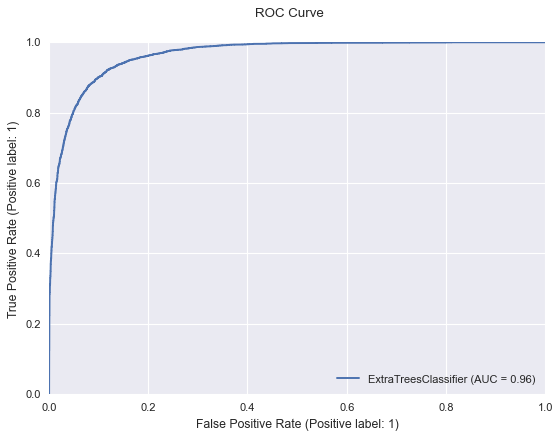

In [87]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

##### I have generated the ROC Curve for my final model and it shows the AUC score for my final model to be of 96%

# Confusion Matrix

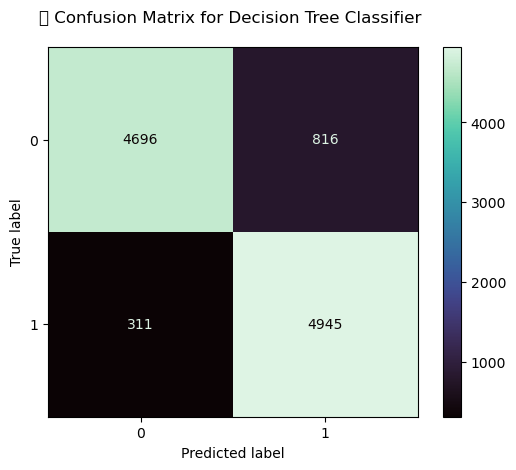

In [88]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

##### With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my ML model missed to provide the correct prediction (depicting in the black boxes).

# Saving the model

In [89]:
filename = "FinalModel_CI.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_CI.pkl']

#### Finally I am saving my best classification model using the joblib library